# GP+PCA detrended WLCs

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob as glob
import matplotlib as mpl
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import seaborn as sns

import bz2
import corner
import json
import pathlib
import pickle
import utils
import warnings

from astropy import constants as const
from astropy import units as uni
from astropy.io import ascii, fits
from astropy.time import Time
from mpl_toolkits.axes_grid1 import ImageGrid

# Default figure dimensions
FIG_WIDE = (11, 5)
FIG_LARGE = (8, 11)

# Figure style
sns.set(style="ticks", palette="colorblind", color_codes=True, context="talk")
params = utils.plot_params()
plt.rcParams.update(params)

## [Dowload data](https://www.dropbox.com/sh/n2mlcmsi9e3g0t6/AAB8n5PKb9MzGq3-BN33Okppa?dl=1)

Unzip this into a folder named `data` in the same level as this notebook

## Plot

In [25]:
data_dirs

['data/detrended/out_l/WASP50/w50_131219_IMACS/white-light',
 'data/detrended/out_l/WASP50/w50_150927_IMACS/white-light',
 'data/detrended/out_l/WASP50/w50_161211_IMACS/white-light']

In [30]:
BMA = pd.read_csv(
    "data/detrended/out_l/WASP50/w50_131219_IMACS/white-light/results.dat",
    comment="#",
    index_col="Variable",
    skipinitialspace=True,
)
BMA

,Value,SigmaUp,SigmaDown
Variable,,,
P,1.955093e+00,2.865000e-07,2.780000e-07
rho,2.056209e+00,9.525598e-02,9.341204e-02
r1,8.094849e-01,9.521169e-03,9.469601e-03
r2,1.396283e-01,1.089906e-03,1.041070e-03
b,7.142273e-01,1.428175e-02,1.420440e-02
p,1.396283e-01,1.089906e-03,1.041070e-03
aR,7.461992e+00,1.134922e-01,1.147531e-01
inc,8.450571e+01,1.888564e-01,1.939108e-01
t0,2.455559e+06,1.492421e-04,1.503704e-04


In [40]:
pg = utils.load_pickle(
    "data/detrended/out_l/WASP50/w50_131219_IMACS/white-light/PCA_1/posteriors_trend_george.pkl"
)
pg["posterior_samples"].keys()

dict_keys(['rho', 'r1', 'r2', 'unnamed', 'mmean', 'ljitter', 't0', 'P', 'q1', 'xc0', 'max_var', 'alpha0', 'alpha1', 'alpha2', 'alpha3', 'alpha4', 'alpha5'])

[0.216863077, 0.78312259, 1.4332419e-05, 4.02567205e-10]
data/detrended/out_l/WASP50/w50_131219_IMACS/white-light/results.dat
xc=array([-2.9206339e-03,  1.4138898e-03, -8.5420900e-05,  2.5135400e-05])
(169,) 2456645.6375593496
0.9916130472402662

(169,) -0.006844088832544378
(169,) 0.00922187223201719
(169,) -0.015970941368479707
(169,) -9.501969608186232e-05


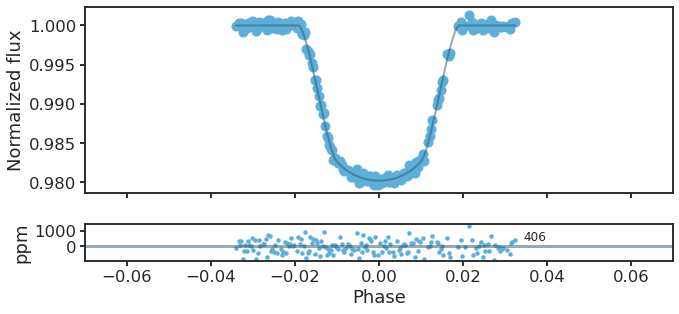

[0.999985701, 1.42987382e-05, 1.61686699e-10, 4.5636483e-15]
data/detrended/out_l/WASP50/w50_150927_IMACS/white-light/results.dat
xc=array([-1.6570951e-03,  9.6537500e-05,  4.9097800e-05, -1.5288370e-04])
(315,) 2457292.81405115
0.9938414033135408

(315,) -0.06490834555365078
(315,) 0.006770591291168656
(315,) -0.07161736360299423
(315,) -6.157324182522833e-05


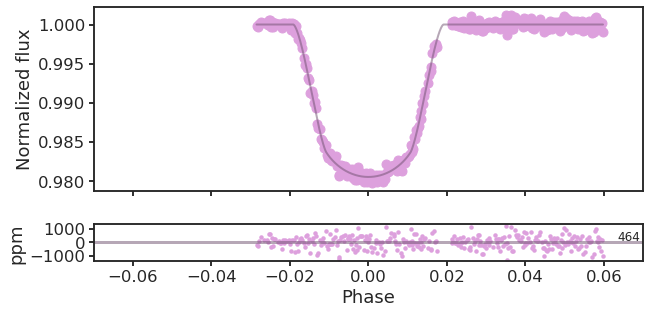

[0.999940563, 5.9436592e-05]
data/detrended/out_l/WASP50/w50_161211_IMACS/white-light/results.dat
xc=array([-0.00649719,  0.0002393 ])
(290,) 2457734.644877286
0.9931475969084352

(290,) 0.03452314151551724
(290,) 0.007531754074659608
(290,) 0.026413739428453206
(290,) 0.0005776480124044245


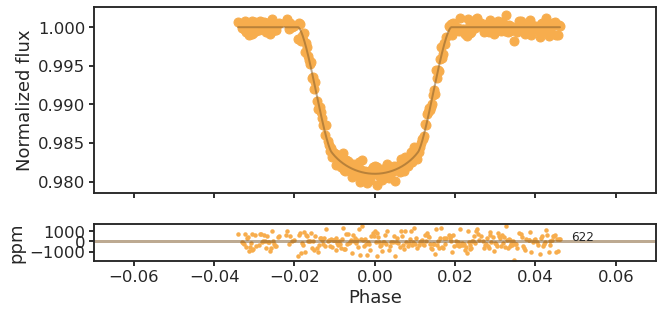

In [29]:
base_dir = "data/detrended/out_l/WASP50"
data_dirs = sorted(glob.glob(f"{base_dir}/w50_*IMACS*/white-light"))
fpaths_dict = {
    f"Transit {i}": fpath for (i, fpath) in enumerate(data_dirs, start=1)
    #if (("150927" not in fpath) and ("161211" not in fpath))
}

for i, (transit_name, transit_path) in enumerate(fpaths_dict.items()):
    fig, axes = plt.subplots(
        2, 1,
        sharex=True,
        gridspec_kw={"height_ratios":[5, 1]}
    )
    ax_top, ax_bottom = axes
    
    with open(f"{transit_path}/results.dat", 'r') as f:
        s = f.readlines()[1]
        Pmodel_strings = s.split('[')[1].split(']')[0].split()
        print([float(Pmodel_string) for Pmodel_string in Pmodel_strings])

    # Compute BMA_WLC
    BMA_WLC = utils.detrend_BMA_WLC(transit_path)
    phase = utils.get_phases(*(BMA_WLC[k] for k in ("t", "P", "t0")))
    
    # Plot BMA WLC and transit model 
    axes[0].plot(
        phase,
        BMA_WLC["LC_det"],
        "o",
        c = f"C{i}",
        #yerr=BMA_WLC["LC_det_err"],
    )
    
    c_dark = 0.5 * np.array(mpl.colors.to_rgba(f"C{i}")[:3])
    t_full, f_full = np.loadtxt(f"{transit_path}/full_model_BMA.dat", unpack=True)
    phase_full = utils.get_phases(t_full, BMA_WLC["P"], BMA_WLC["t0"])
    axes[0].plot(
        phase_full,
        f_full,
        c = c_dark,
        lw=2,
        alpha=0.5,
    )
    
    # Residuals
    resids = BMA_WLC["LC_det"] - BMA_WLC["LC_transit_model"]
    ax_bottom.plot(phase, resids * 1e6, '.', c=f"C{i}", mew=0)
    ax_bottom.axhline(0, c=c_dark, lw=3, alpha=0.5)

    trans = transforms.blended_transform_factory(
        ax_bottom.transData, ax_bottom.transAxes
    )
    rms = np.std(resids) * 1e6
    ax_bottom.annotate(
        f"{int(rms)}",
        xy = (1.06*phase[-1], 0.55),
        xycoords = trans,
        fontsize = 12,
    )

    # Save
    ax_top.set_xlim(-0.07, 0.07)
    ax_bottom.set_xlabel("Phase")
    ax_top.set_ylabel("Normalized flux")
    ax_bottom.set_ylabel("ppm")
    fig.tight_layout()
    fig.set_size_inches(FIG_WIDE)
    title = transit_name.lower().replace(" ", "_") + "_detr_wlcs"
    #utils.savefig(f"../paper/figures/detrended_wlcs/{title}.pdf")
    
    plt.show()

## Fitted parameters table

In [4]:
data_dict = {k:f"{v}/results.dat" for k, v in fpaths_dict.items()}

# Truths from Sada and Ramon (2016) + GAIA DR2
with open(f"{base_dir}/truth.json", "rb") as f:
    parameters = json.load(f)

# Add depth to top of dictionary. This sets the order in the final table
depth_dict = {
    "d":{
        "symbol": "$\delta$",
        "definition": "transit depth (ppm)"
    }
} 
parameters = {**depth_dict, **parameters}

# Holds results from each transit
results_dict = {}
for transit, fpath in data_dict.items():
    results_dict[transit] = pd.read_table(fpath, sep='\s+', comment='#', index_col="Variable")
    results_dict[transit].at["t0", "Value"] -= 2.45e6
    
    p_val, p_u, p_d = results_dict[transit].loc["p"].values.T
    results_dict[transit].loc["d"] = p_val**2 * 1e6, 2e6 * p_val * p_u, 2e6 * p_val * p_d

# Create summary table of all transits
results_dict_latex = {}
results_dict_latex["parameter"] = [p["symbol"] for p in parameters.values()]
#results_dict['definition'] = [p["definition"] for p in parameters.values()]
for transit, results in results_dict.items():
    results_dict_latex[transit] = []
    for param, param_info in parameters.items():
        fmt_vals = {"fmt_v":".4g", "fmt_vu":".4g", "fmt_vd":".4g"}
        
        results_dict_latex[transit].append(
            utils.write_latex_row(results.loc[param], **fmt_vals)
        )
        
combined = []
for param in parameters.keys():
    vs, vus, vds = [], [], []
    for (k, v) in results_dict.items():
        v, vu, vd = v.loc[param]
        vs.append(v)
        vus.append(vu)
        vds.append(vd)

    combined.append(
        utils.write_latex_single_sig_fig(
            utils.weighted_mean_uneven_errors(vs, vus, vds),
            fmt_v = ".10f",
            fmt_verr = ".3g",
        )
    )
    
results_dict_latex["Combined"] = combined
        
results_table = pd.DataFrame(results_dict_latex)
results_table#.to_clipboard(index=False)

,parameter,Transit 1,Transit 2,Transit 3,Combined
0,$\delta$,1.93e+04^{+423.7}_{-396.9},1.899e+04^{+234.6}_{-233.7},1.874e+04^{+599.4}_{-581.1},19027.5224677496 \pm 192
1,Rₚ/Rₛ,0.1389^{+0.001525}_{-0.001429},0.1378^{+0.0008513}_{-0.0008481},0.1369^{+0.002189}_{-0.002122},0.1379439138 \pm 0.000697
2,t₀,5559^{+0.0001841}_{-0.0001762},5559^{+0.0001827}_{-0.0001801},5559^{+0.0001846}_{-0.000182},5558.6123563074 \pm 0.000105
3,P,1.955^{+4.206e-07}_{-4.278e-07},1.955^{+2.451e-07}_{-2.466e-07},1.955^{+2.488e-07}_{-2.442e-07},1.9550931609 \pm 1.61e-07
4,ρₛ,2.012^{+0.1056}_{-0.0893},2.098^{+0.08378}_{-0.08061},2.091^{+0.1018}_{-0.09438},2.0674427747 \pm 0.0529
5,a/Rₛ,7.409^{+0.1274}_{-0.1113},7.513^{+0.09868}_{-0.09746},7.503^{+0.1199}_{-0.1147},7.4776305048 \pm 0.0637
6,i,84.42^{+0.2079}_{-0.1892},84.64^{+0.1656}_{-0.1581},84.65^{+0.1966}_{-0.193},84.5750857980 \pm 0.105
7,b,0.7205^{+0.01361}_{-0.01537},0.7024^{+0.01207}_{-0.01317},0.6995^{+0.01486}_{-0.01601},0.7077707835 \pm 0.0081
8,u,0.5056^{+0.06537}_{-0.07035},0.5714^{+0.04204}_{-0.04527},0.5428^{+0.07016}_{-0.07335},0.5516190206 \pm 0.0327
